# Mecánica Celeste: teoría, algoritmos y problemas
## Jorge I. Zuluaga
### Taller: la aproximación de Apophis de abril de 2029

###Presentado por: Mariana Gómez Cuartas


En este taller exploraremos las propiedades de la órbita del Asteroide (99942) Apophis, que realizará una aproximación a la Tierra prevista para el mes de abril de 2029

## Herramientas requeridas

Instalemos e importemos los paquetes requeridos:

In [ ]:
!pip install -Uq pymcel

In [ ]:
import pymcel as pc
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import spiceypy as spy

deg = np.pi/180
rad = 1/deg
pc.descarga_kernels()

Descargando kernel 'de430.bsp' en 'pymcel/'...
El kernel 'de430.bsp' ya fue descargado
Descargando kernel 'de430_tech-comments.txt' en 'pymcel/'...
El kernel 'de430_tech-comments.txt' ya fue descargado
Descargando kernel 'latest_leapseconds.tls' en 'pymcel/'...
El kernel 'latest_leapseconds.tls' ya fue descargado
Descargando kernel 'naif0012.tls' en 'pymcel/'...
El kernel 'naif0012.tls' ya fue descargado
Descargando kernel 'earth_latest_high_prec.bpc' en 'pymcel/'...
El kernel 'earth_latest_high_prec.bpc' ya fue descargado
Descargando kernel 'earth_fixed.tf' en 'pymcel/'...
El kernel 'earth_fixed.tf' ya fue descargado
Descargando kernel 'gm_de431.tpc' en 'pymcel/'...
El kernel 'gm_de431.tpc' ya fue descargado
Descargando kernel 'pck00011.tpc' en 'pymcel/'...
El kernel 'pck00011.tpc' ya fue descargado


## Elementos orbitales presentes

Para empezar necesitamos los elementos orbitales presentes de Apophis y la Tierra. Para ello usaremos `astroquery` y en particular el *wrap* de `pymcel` para acceder a datos de esta plataforma. Así se obtienen los elementos orbitales del baricentro de la Tierra y la Luna por ejemplo:


In [ ]:
fecha_inicial = '2024-04-09 00:00:00'
tabla, tini, tierra = pc.consulta_horizons(           #tini es tiempos
    id='3',location='@0',epochs=fecha_inicial,
    datos='elements'
)
ap, ep, Ip, Wp, wp, fpo, Mpo, Pp, nmp, tpo = tierra     #nm es mean notion (n) #p (planeta)
tierra    #sale en unidades del SI (relativos al baricentro del sistema solar)

array([1.52000960e+11, 1.83906615e-02, 1.32168293e-02, 1.20147331e+02,
       7.93493603e+00, 7.12682137e+01, 6.92813300e+01, 3.73844161e+02,
       1.94525045e-07, 2.46033755e+06])

**Ejercicio**: obtenga los elementos orbitales de Apophis para la fecha inicial

In [ ]:
tabla_b, tini_b, apophis = pc.consulta_horizons(           #tini es tiempos
    id='99942',location='@0',epochs=fecha_inicial,
    datos='elements'
)
ab, eb, Ib, Wb, wb, fbo, Mbo, Pb, nmb, tbo = apophis     #todos los angulos estan en grados #periodo en dias
apophis

array([1.34596214e+11, 1.77215232e-01, 3.34954417e+00, 2.04104555e+02,
       1.26818205e+02, 2.20094131e+01, 1.52518312e+01, 3.11507419e+02,
       2.33452071e-07, 2.46039630e+06])

Como la masa de Apophis es casi despreciable, usando el semiejemayor y el movimiento medio del cuerpo podemos calcular el valor de $\mu$ del sistema solar:

In [ ]:
#usar tercera ley de kepler para hallar el mu
mu = ab**3*nmb**2
mu


#mov apohis resp baricentro, el mu incluye la masa de todo el sistema solar

1.3289051882019878e+20

In [ ]:
pc.constantes.GM_sun

1.3271244e+20

## Unidades canónicas

Antes de continuar es conveniente definir un sistema de unidades canónicas y pasar todas las cantidades implicadas a este nuevos sistema de unidades. Para ello usaremos como unidad de longitud 1 au y como unidad de masa la masa calculada para el sistema solar usando los datos de Apophis:

In [ ]:
UL = 1*pc.constantes.au
UM = mu/pc.constantes.G

**Ejercicio**: calcule los factores de conversión para la unidad de tiempo (UT), la unidad de velocidad (UV), la unidad de velocidad angular (UN).

In [ ]:
G = pc.constantes.G
UT = np.sqrt(UL ** 3 / (G * UM))
UV = UL / UT
UN = 1 / UT     #Unidad canónica de velocidad angular

UT, UV, UN

(5019276.488401785, 29804.66827154889, 1.9923190171147864e-07)

Con los factores de conversión podemos obtener los elementos de la Tierra en unidades canónicas:

In [ ]:
ap = ap/UL
nmp = nmp * rad * 86400
Pp = Pp*86400/UT
tpo = tpo*86400/UT
print("Tierra:",ap, nmp, Pp, tpo)

Tierra: 1.016063660670122 0.9629680953834889 6.435217428845342 42351.35585581539


**Ejercicio**: convierta los elementos orbitales de Apophis a las unidades canónicas. Deje los ángulos expresados en grados.

In [ ]:
ab = ab/UL
nmb = nmb/UN
Pb = Pb*86400/UT     #UT esta en segudnos --> convierto el periodo en segundos y luego a la unidad canónica
tbo = tbo*86400/UT
print("Apophis:",ab, nmb, Pb, tbo)    #nos debe dar de orden 1

Apophis: 0.899720119948829 1.1717604930254206 5.362175414326139 42352.36712644791


## Gráfico de las órbitas osculatrices

Teniendo los elementos orbitales de los cuerpos podemos hacer un gráfico de las dos órbitas en sus respectivos sistemas de referencia naturales:

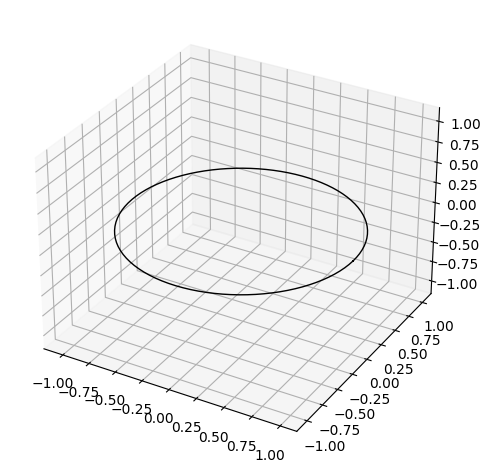

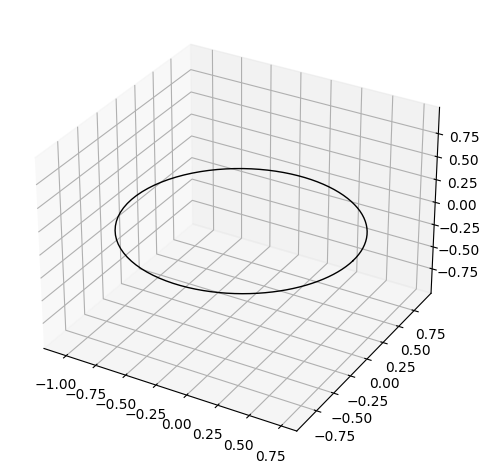

In [ ]:
#cálculo de la orbita en el sis de referencia natural

Nf = 100
fs = np.linspace(0,2*np.pi,Nf)

rps = ap*(1-ep**2)/(1+ep*np.cos(fs))
xps = rps*np.cos(fs)
yps = rps*np.sin(fs)
zps = 0*rps                #así para que sea un vector de ceros
rpsvec = np.vstack((xps,yps,zps)).T   #toma 3 listas y las organiza una al lado de la otra en una matriz (vector columna)

rbs = ab*(1-eb**2)/(1+eb*np.cos(fs))
xbs = rbs*np.cos(fs)
ybs = rbs*np.sin(fs)
zbs = 0*rbs
rbsvec = np.vstack((xbs,ybs,zbs)).T

fig1 = pc.plot_doscuerpos_3d(rpsvec,rpsvec,tipo='matplotlib')
fig2 = pc.plot_doscuerpos_3d(rbsvec,rbsvec,tipo='matplotlib')

# las órbitas no pueden ir juntas porque están en planos diferentes

Ahora necesitamos calcular las posiciones de los cuerpos en el sistema de referencia de las observaciones. Para ello necesitamos construir las matrices que transforman del sistema de referencia natural de las cónicas al sistema de referencia de la observación.

**Ejercicio**: Calcule las matrices de transformación para la Tierra y para Apophis usando la rutina `eul2m` de `spiceypy`:

In [ ]:
#queremos pasar del sistema natural al sistema de observacion

Mpinv = spy.eul2m(-Wp * deg, -Ip * deg, -wp * deg, 3, 1, 3)
Mbinv = spy.eul2m(-Wb * deg, -Ib * deg, -wb * deg, 3, 1, 3)
Mpinv, Mbinv

(array([[-6.16792290e-01, -7.87125931e-01,  1.99475060e-04],
        [ 7.87125956e-01, -6.16792280e-01,  1.15851909e-04],
        [ 3.18446355e-05,  2.28468561e-04,  9.99999973e-01]]),
 array([[ 0.87340681,  0.48640636, -0.02386188],
        [-0.48473991,  0.87303085,  0.05333252],
        [ 0.04677343, -0.03501418,  0.99829167]]))

**Ejercicio**: Usando las matrices de transformación, escriba las posiciones de la Tierra y de Apophis y haga un gráfico de las órbitas resultantes usando `plot_ncuerpos_3d`.

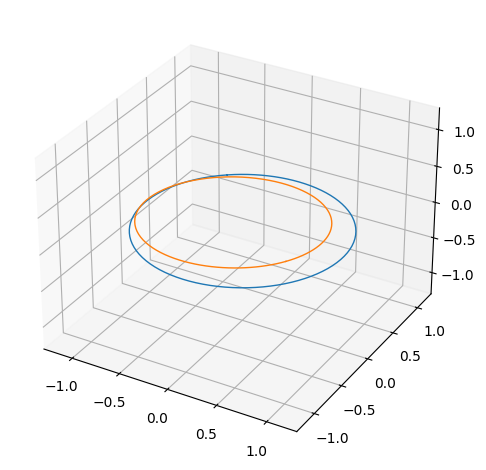

In [ ]:
rps = np.zeros_like(rpsvec)
rbs = np.zeros_like(rbsvec)

for i in range(Nf):
  rpsvec_ = spy.mxv(Mpinv, np.array(rpsvec[i]))      #revisar luegoesto, que debe dar pla otro lado
  rbsvec_ = spy.mxv(Mbinv, np.array(rbsvec[i]))
  rps[i] = rpsvec_
  rbs[i] = rbsvec_

# Así se pueden concatenar los datos resultantes para usar la rutina
rsvec = np.zeros((2,Nf,3))
rsvec[0] = rps
rsvec[1] = rbs

fig = pc.plot_ncuerpos_3d(rsvec,rsvec,tipo='matplotlib')

**Ejercicio**: Escriba una rutina que dado un conjunto de elementos orbitales $a,e,I,\Omega,\omega,f$ calcule la posición del cuerpo.

In [ ]:
def elementos_a_posicion(elementos_fijos,f):
  a,e,I,W,w = elementos_fijos


  r = a*(1-e**2)/(1+e*np.cos(f))
  x = r*np.cos(f)
  y = r*np.sin(f)
  z = 0
  rsvec = np.array([x, y, z])

  Minv = spy.eul2m(-W, -I, -w, 3, 1, 3)
  rvec = spy.mxv(Minv, rsvec)

  return rvec     #en el sistema de referencia del observador

Podemos probar la rutina con el primer valor calculado antes:

In [ ]:
elementos_a_posicion([ap,ep,Ip*deg,Wp*deg,wp*deg],fs[0])

array([-6.15174800e-01,  7.85061779e-01,  3.17611254e-05])

Que debe coincidir con el primer valor de la tabla de posiciones de los cuerpos:

In [ ]:
rsvec[0,0]

array([-6.15174800e-01,  7.85061779e-01,  3.17611254e-05])

## Cálculo del MOID

Teniendo los elementos orbitales de ambos cuerpos, podemos ahora intentar calcular el denominado *Minimal orbital intersection distance* (MOID) de ambos cuerpos. Para ello usaremos la siguiente idea.

Dados dos cuerpos para los cuáles son conocidos sus elementos orbitales, y dos anomalías verdaderas $f_1$ y $f_2$, las posiciones de los cuerpos están dadas por $\vec r_1(f_1)$ y $\vec r_1(f_2)$. La distancia entre ellos será:

$$
D(f_1,f_2) = |\vec r_1(f_1)-\vec r_2(f_2)|
$$

Para calcular el MOID debemos calcular el mínimo de la función $D(f_1,f_2)$. Podemos estudiar el comportamiento de la funciónd $D$ generando un `meshgrid` para $f_1$ y $f_2$ y haciendo un gráfico de calor de $D$.

**Ejercicio**: Usando la rutina `elementos_a_posicion` cree una rutina que dados dos conjuntos de elementos fijos y sus respectivas anomalías verdaderas, calcule la distancia entre los dos cuerpos:

In [ ]:
def distancia_orbitas(elementos_fijos_1,elementos_fijos_2,f1,f2):

  r1 = elementos_a_posicion(elementos_fijos_1, f1)
  r2 = elementos_a_posicion(elementos_fijos_2, f2)

  r12 = r1 - r2
  D = np.linalg.norm(r12)

  return D

Probemos otra vez en el caso de nuestros cuerpos:

In [ ]:
elementos_fijos_p = [ap,ep,Ip*deg,Wp*deg,wp*deg]
elementos_fijos_b = [ab,eb,Ib*deg,Wb*deg,wb*deg]
D = distancia_orbitas(elementos_fijos_p,elementos_fijos_b,fpo,fbo)
D     #en unidades astronómicas

1.5907579927240372

Vamos ahora a explorar el espacio de $f_1$ y $f_2$ para ver dónde ocurre un mínimo:

In [ ]:
Ng = 30
F1,F2 = np.meshgrid(np.linspace(0,2*np.pi,Ng),np.linspace(0,2*np.pi,Ng))       #discretizar el espacio de las variables en una maya
D = np.zeros_like(F1)
for i in range(Ng):
  for j in range(Ng):
    D[i,j] = distancia_orbitas(elementos_fijos_p,elementos_fijos_b,F1[i,j],F2[i,j])

Un gráfico de contornos nos muestra el comportamiento de la distancia:

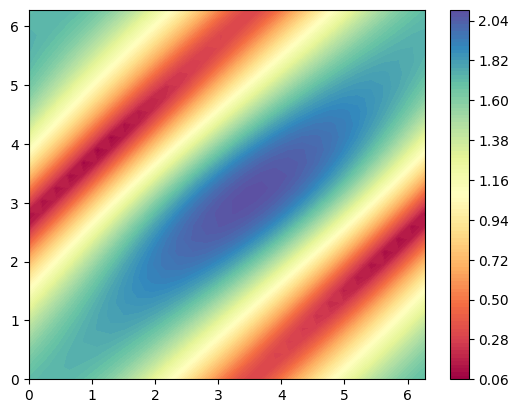

In [ ]:
plt.contourf(F1,F2,D,100,cmap='Spectral')
plt.colorbar()

La siuguiente rutina se usa para minimizar la distancia:

In [ ]:
def distancia(X):          #recibe F1 y F2 pero como vector
  D = distancia_orbitas(elementos_fijos_p,elementos_fijos_b,X[0],X[1])
  return D

Ahora podemos minimizar:

In [ ]:
from scipy.optimize import minimize
minimize(distancia,[np.pi,np.pi])

#fun es el moid --> minima distancia a la que se acercan apophis y la Tierra

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.012353328915964414
        x: [-5.150e+00  1.644e+01]
      nit: 14
      jac: [-1.955e-07  3.027e-07]
 hess_inv: [[ 4.723e-01  4.628e-01]
            [ 4.628e-01  4.656e-01]]
     nfev: 117
     njev: 39

## Propagación en el tiempo

Vamos ahora a propagar la órbita de los cuerpos en el tiempo hasta una fecha futura:

In [ ]:
fecha_final = '2029-04-13 00:00:00'
tfin = Time(fecha_final).jd
tfin, tini

/usr/local/lib/python3.10/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


(2462239.5, 2460409.5)

**Ejercicio**: Calcule la anomalia media de los cuerpos en el momento futuro:

Vamos a tener en cuenta lo siguiente:

$$M_{ini} = n ( t_{ini} - t_p)$$
$$M_{fin} = n ( t_{ini} - t_p)$$

Restando:
$$M_{fin}-M_{ini} = n (t_{fin} - t_{ini})$$


In [ ]:
Mpfin = Mpo + nmp * (tfin - tini)
Mbfin = Mbo + nmb * (tfin - tini)

Mpfin = np.mod(Mpfin, 360)
Mbfin = np.mod(Mbfin, 360)

Mpo, Mpfin, Mbo, Mbfin     #los iniciales vienes de astroquery

(69.28132998154351, 31.51294453332821, 15.25183123653674, 359.5735334730566)

Ahora necesitamos calcular la anomalía excéntrica, para lo cuál usaremos el método de Newton:

In [ ]:
Epfin, error, niter = pc.kepler_newton(Mpfin*deg, ep, Mpfin*deg)
Epfin = Epfin*rad
Epfin

32.07246728894829

In [ ]:
pc.kepler_newton??

**Ejercicio**: Calcule la anomalía excéntrica de Apophis y la anomalía verdadera de ambos cuerpos.

In [ ]:
Ebfin, error, niter = pc.kepler_newton(Mbfin*deg, eb, Mbfin*deg)
Ebfin = Ebfin*rad
Ebfin

Ebfin

359.48168057737206

**Ejercicio**: Calcule la anomalía verdadera de ambos cuerpos.

Para el cálculo de la anomalía verdadera, vamos a tener en cuenta que:

$$tan(\frac{f}{2}) = \sqrt{\frac{1+e}{1-e}}tan(\frac{E}{2})$$

In [ ]:
raiz_p = np.sqrt((1 + ep)/(1-ep))
raiz_b = np.sqrt((1 + eb)/(1-eb))
fpfin = 2 * np.arctan(raiz_p * np.tan(Epfin*deg/2)) *rad       #recordamos que E venía en grados del procedimiento anterior
fbfin = 2 * np.arctan(raiz_b * np.tan(Ebfin*deg/2)) *rad

fpfin, fbfin

(32.636414240200345, -0.6199847711736839)

Usando el resultado podemos obtener las posiciones finales y calcular la distancia:

**Ejercicio**: Calcule las posiciones finales y la distancia.

Para estudiar la aproximación, podemos ahora hacer un gráfico de la distancia para fechas entre el mes de marzo y el mes de mayo de 2029.

**Ejercicio**: Haga un gráfico de las distancias entre la Tierra y Apophis en el intervalo del 1 de marzo de 2029 y 1 de mayo de 2029.

comenzamos definiendo las fechas iniciales y finales (en JD)

In [ ]:
fecha_ini = '2029-03-01 00:00:00'
tinicial = Time(fecha_ini).jd

fecha_fin = '2029-05-01 00:00:00'
tfinal = Time(fecha_fin).jd

tinicial, tfinal

(2462196.5, 2462257.5)

Definimos los tiempos asociados al intervalo

In [ ]:
tiempos = np.arange(tinicial, tfinal, 0.25)   #de a 0.25 días

In [ ]:
#retomamos parte del código realizado en la parte previa

elementos_fijos_p = [ap,ep,Ip*deg,Wp*deg,wp*deg]
elementos_fijos_b = [ab,eb,Ib*deg,Wb*deg,wb*deg]

In [ ]:
def hallar_f(tfin):
  Mpfin = Mpo + nmp * (tfin - tini)
  Mbfin = Mbo + nmb * (tfin - tini)

  Mpfin = np.mod(Mpfin, 360)
  Mbfin = np.mod(Mbfin, 360)

  Epfin, error, niter = pc.kepler_newton(Mpfin*deg, ep, Mpfin*deg)
  Epfin = Epfin

  raiz_p = np.sqrt((1 + ep)/(1-ep))
  raiz_b = np.sqrt((1 + eb)/(1-eb))
  fpfin = 2 * np.arctan(raiz_p * np.tan(Epfin/2))      #recordamos que E venía en grados del procedimiento anterior
  fbfin = 2 * np.arctan(raiz_b * np.tan(Ebfin/2))

  return fpfin, fbfin

In [ ]:
#determinación de las distancias entre la Tierra y Apophis en cada punto
D = np.zeros_like(tiempos)

for i, j in enumerate(tiempos):
  fp = hallar_f(j)[0]
  fb = hallar_f(j)[1]
  dp= elementos_a_posicion(elementos_fijos_p,fp)
  db = elementos_a_posicion(elementos_fijos_b,fb)
  D[i] = np.linalg.norm(dp-db)

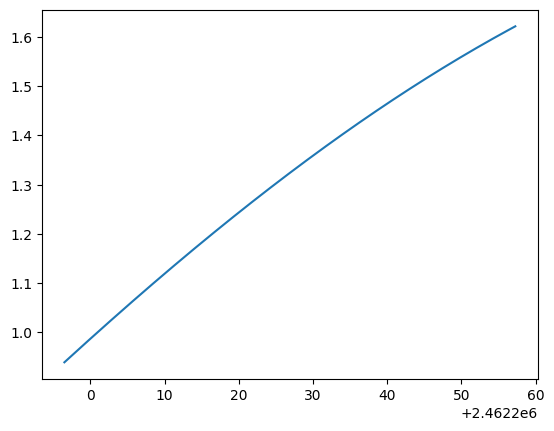

In [ ]:
plt.plot(tiempos, D);